# Neural Network Baaaaasics using a simple ‘swarm’

Aidan Morrison, 25/05/2020

## Let's break it right down

Neural networks are pretty cool right now.  Especially deep ones, which are great for doing traditionally difficult high-dimensional tasks, like image classification.  But figuring out how to design a good network and associated training regime for a given task is tricky.  Many wouldn't know where to start.

So let's start at the very beginning... A simple feed-forward neural network with one hidden layer, trying to predict a simple, noiseless function (say, a sin wave) in just one dimension.

Sound's boring?? Great! We can help make neural networks 'uncool' again, and maybe learn something that helps in the complex cases too.

## Why swarm?

Because we can.

Generalisation is hard. There's always a chance that the particular network configuration you've achieved is a fluke. Erratic behaviour is common enough. People only share their best results. So while we've got a case simple enough to train as many different networks as we like, let's do that. We'll train a whole bunch of 'bees', which are new networks that have got the same architecture and same training regime.  The random starting weights and biases are all that differentiate each bee. So by training a whole 'swarm' of bees, we can get a better sense of how the regime and architecture works, on average, rather than judging on a spurious result.

In [1]:
import numpy as np
import torch
from torch import nn

from swarm import core, animator, networks, regimes
import env

from matplotlib import pyplot as plt
from IPython.display import Video

import seaborn as sns
sns.set()

plt.rcParams["figure.figsize"] = (12.0, 12.0)


In [2]:
SEED = 10
NUM_BEES = 10

if env.FULL:
    NUM_EPOCHS = 150
else:
    NUM_EPOCHS = 15
    


In [3]:

def example_swarm():
    # define the x and y
    x = torch.linspace(-5, 5, 61)
    y = torch.sin(x)
    # define the neural network training params that won't change
    static = {"x": x, "y": y, "hidden": 1, "momentum":0.9, "lr": 0.01, "num_epochs": NUM_EPOCHS}
    pm = core.make_combo_paramsets(
        static,
        # sweep across width
        width = [1,3,10],
        # and activations
        activation=[nn.ReLU, nn.Tanh, nn.Tanhshrink],
    )
    # give us the results 
    res = core.hive_trainer(regimes.default_train, param_list=pm, num_bees=NUM_BEES, seed=SEED, fields="ypred,loss")
    return res

In [4]:
first_swarm = example_swarm()


In [5]:
# some cleanup for plotting
for s in first_swarm:
    s["activation"] = s["activation"].__name__

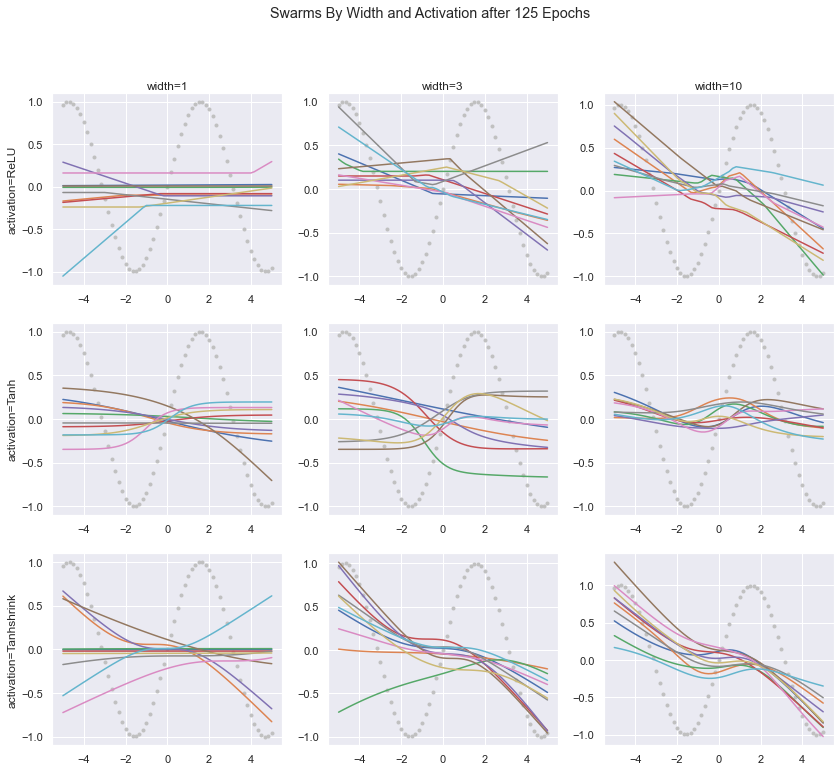

In [6]:

ans = animator.hive_plot(first_swarm, "width", "activation", NUM_EPOCHS-1)
ans.suptitle("Swarms By Width and Activation after 125 Epochs");

The left-hand column shows us the most basic case, where we have only 1 neuron. Then, all that the ‘network’ can do is fit a weight and bias to the activation function itself. And what are those? Well, in this case we’re just contrasting three. The traditional ReLU is a just a straight, flat line, that tilts up to a straight incline at at a point (zero by default). The next one is a popular trig function, tanh. Then, just for fun, we’ve added ‘x-tanh’, a novel activation of our own invention which, unlike the others, has a nonzero gradient almost everywhere. A straight line of gradient one, that flattens in the middle.

Being smoother, the trig functions fit the rounded shape of the sin curve much better. But apart from being smooth, they also have other nuanced traits. Notice that the tanh tends to fit the central slope most quickly. But even with a width of 10, struggles to capture the symmetric nature of the dip and hump either side of the cuve. The ‘x-tanh’ activations, whilst slower to reach the top and bottom of the dip and hump, arch into the curves much better once they get there.

Let’s examine the actual functions to explore why.

## Activation Functions

Let’s have a look at what the activation functions look like on their own.

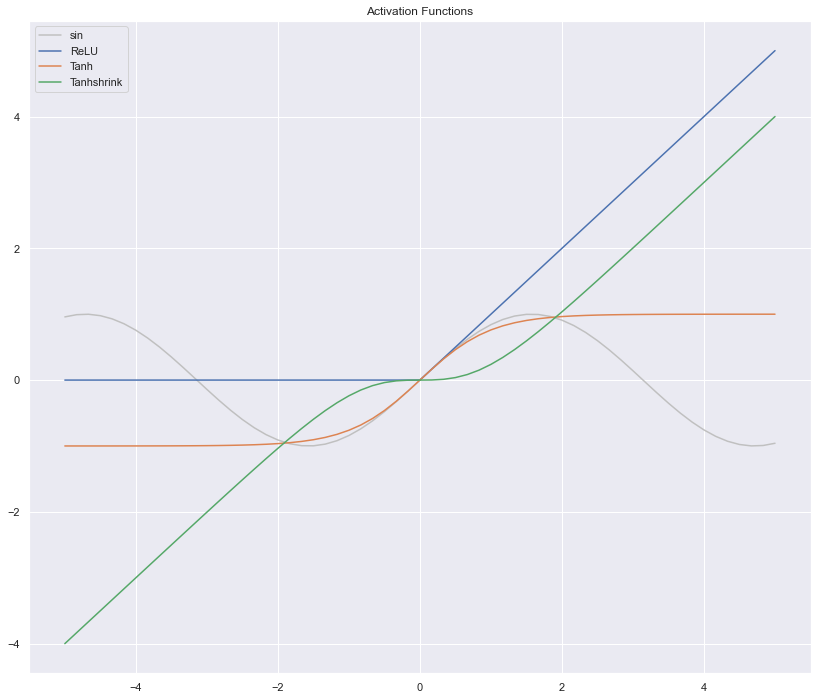

In [7]:
x = torch.linspace(-5, 5, 61)
activations = [nn.ReLU, nn.Tanh, nn.Tanhshrink]
plt.plot(x, torch.sin(x), color='silver', label='sin')
for activ in activations:
    activ_f = activ()
    plt.plot(x, activ_f(x), label=activ.__name__)
plt.legend()
plt.title("Activation Functions");

It’s easy to see that the ‘tahh’ line fits the greatest part of the sine curve we’re approximating. Let’s have a look at how these shapes show up in the initial (random) starting positions of all the lines.

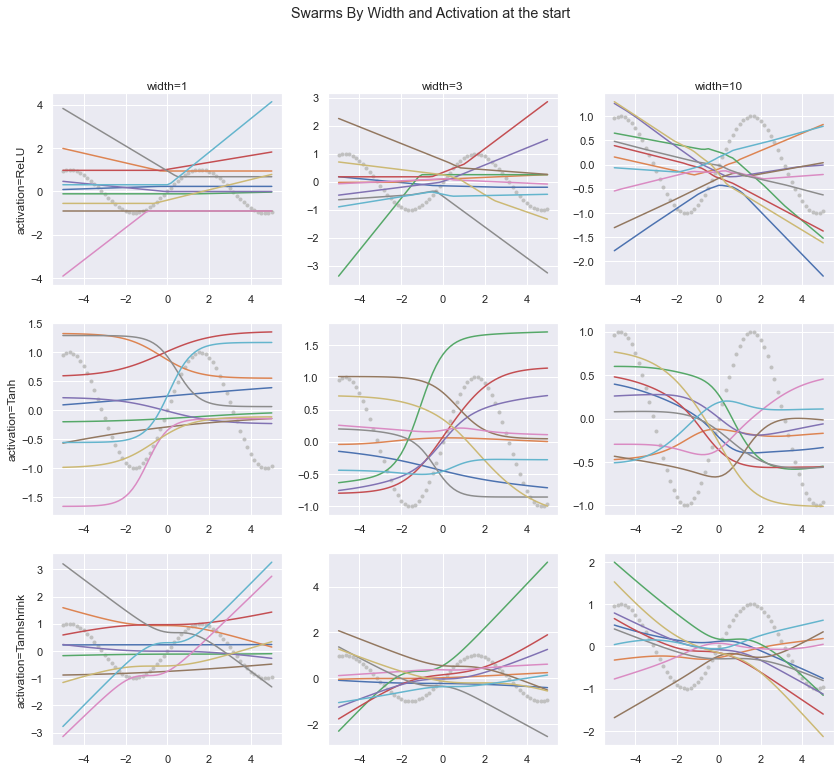

In [8]:
ans = animator.hive_plot(first_swarm, "width", "activation", 0)
ans.suptitle("Swarms By Width and Activation at the start");

We can see here that what it looks like to randomly select curves/lines from the possibilities created by a single one of the activation functions with just one weight and bias. The ReLU curves have just a single kink. The tanh curves have a slope that’s steepest somewhere near the middle of the line. The x-tanh curves are flat somewhere in the middle, and steep(er) towards the ends. As more neurons are added in the middle and right columns, you can directly see how additional ‘kinks’ appear in the relu curves, and the trig functions can take more complex shapes.

Finally, let’s see an animation of how the training evolves over time.

In [11]:
plt.rcParams["figure.figsize"] = (10.0, 10.0)
animator.hive_animate(first_swarm, "width", "activation", 'first_swarm.mp4')

Saved to first_swarm.mp4


In [12]:


Video("first_swarm.mp4", embed=True)

Now that’s kinda cool. (I mean, really un-cool.) You can see a range of effects that beg further exploration. Some of the bees (individual lines) bounce around considerably, and the loss of the fits seems to oscillate. Some of them get into a good position fairly early on, and continue to improve quickly. Others find themselves in a poorer position, and struggle to catch up.

That said, given enough epochs, it looks as though almost all of these networks will find a decent fit, eventually. That’s a luxurious position we can arrive at quite easily with such a simple problem of 1-d noisless data, where training is cheap. But avoiding finding yourself stuck with a poor performer that hasn’t yet found its way a decent amount of training, or worse avoiding an architecture or training regime that doesn’t (quickly) converge to a good fit are very much enduring challenges in machine learning engineering.

In a subsequent post, we’ll explore how the number of epochs, momentum, and learning rate interact with our basic swarm examples.